# IMPORTANT: 
# You must also edit:
# 1. 04_ref_design/sim/SimulationCtrl_tb.vhd 
# AND 
# 2. 04_ref_design/sim/Simulation_FileIO_pkg.vhd 

# !!!

Mono8 can only represent pixel values about to 255, but the framegrabber requires **TODO**: explain what I'm doing here

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from tqdm import tqdm

np.random.seed(0)

Globals

In [2]:
IN_ROWS = 300 # NOTE: Must be a multiple of 16!
IN_COLS = 512 # NOTE: Must be a multiple of 16!
OUT_ROWS = 48
OUT_COLS = 48
IMG_COL_BITWIDTH = int(np.ceil(np.log2(IN_COLS+1))+1)
IMG_ROW_BITWIDTH = int(np.ceil(np.log2(IN_ROWS+1))+1)
NUM_CROPS = 5

# 32x32_to_5x5x5
# TOP_LEFT_Y1X1 = [(0,0),
#                 (0,3),    # 0<-->1 left-right overlap 
#                 (2,0),   # 1<-->2 top-bottom overlap
#                 (4,4),     # 1<-->3 bottom-right corner overlap
#                 (IN_ROWS-OUT_ROWS, IN_COLS-OUT_COLS)
#                 ]

# # 100x160_to_48x48x5
# TOP_LEFT_Y1X1 = [(10,10),
#                 (10,37),    # 0<-->1 left-right overlap 
#                 (23,10),   # 1<-->2 top-bottom overlap
#                 (43,53),     # 1<-->3 bottom-right corner overlap
#                 (52, 99)     # 4 by itself, no overlap
#                 ]

# # 300x512_to_48x48x5
TOP_LEFT_Y1X1 = [(0,0),
                (0,30),    # 0<-->1 left-right overlap 
                (20,0),   # 1<-->2 top-bottom overlap
                (40,40),     # 1<-->3 bottom-right corner overlap
                (IN_ROWS-OUT_ROWS, IN_COLS-OUT_COLS)
                ]

TESTBENCH_TYPE = "VALUE_EQUALS_INDEX"
assert(TESTBENCH_TYPE in ["VALUE_EQUALS_INDEX"]) # ["REAL_DATA", "VALUE_EQUALS_INDEX", "RANDOM"])
if TESTBENCH_TYPE=="VALUE_EQUALS_INDEX":
    FP_FRAC = 0 # We just want integer values corresponding to the index of each pixel
    FP_INT = 8 # int(np.log2(IN_ROWS*IN_COLS)) + 1 
    FP_TOTAL = FP_FRAC + FP_INT # UNSIGNED!
    DATA_STRING_INSERT = "_INDEX"
    VMAX = IN_ROWS*IN_COLS
elif TESTBENCH_TYPE=="REAL_DATA":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT # UNSIGNED!
    DATA_STRING_INSERT = ""
    VMAX = 1
elif TESTBENCH_TYPE=="RANDOM":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT # UNSIGNED!
    DATA_STRING_INSERT = "_RANDOM"
    VMAX = 1
else: raise NotImplementedError

print(f"IMG_COL_BITWIDTH: {IMG_COL_BITWIDTH}")
print(f"IMG_ROW_BITWIDTH: {IMG_ROW_BITWIDTH}")
print(f"FP_TOTAL: {FP_TOTAL}")
print(f"FP_INT: {FP_INT}")
print(f"FP_FRAC: {FP_FRAC}")
print(f"DATA_STRING_INSERT: {DATA_STRING_INSERT}")


top_level_dir = os.path.join("/home/aelabd/RHEED/CoaxlinkQuadCxp12_1cam/tb_data_Mono8", f"{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}")
os.makedirs(top_level_dir, exist_ok=True)

IMG_COL_BITWIDTH: 11
IMG_ROW_BITWIDTH: 10
FP_TOTAL: 8
FP_INT: 8
FP_FRAC: 0
DATA_STRING_INSERT: _INDEX


Helper functions

In [3]:
def generate_binary_numbers(n_bits):
    return np.array([''.join(bits) for bits in itertools.product('01', repeat=n_bits)])

def bin_to_int(bin_str):
    int_val = 0
    for i, bit in enumerate(bin_str[::-1]):
        int_val += int(bit)*(2**i)
    return int_val

def bin_to_frac(bin_str):
    frac_val = 0
    for i, bit in enumerate(bin_str):
        frac_val += int(bit)*(2**(-i-1))
    return frac_val

def frac_to_bin(frac, n_bits=FP_TOTAL):
    bin_str = ""
    for i in range(n_bits):
        if frac >= 2**(-i-1):
            bin_str += "1"
            frac -= 2**(-i-1)
        else:
            bin_str += "0"
    return bin_str

def int_to_bin(int_num, n_bits):
    bin_str = ""
    for i in range(n_bits):
        if int_num >= 2**(n_bits-i-1):
            bin_str += "1"
            int_num -= 2**(n_bits-i-1)
        else:
            bin_str += "0"
    return bin_str

## 1. Input data

i.e. the un-cropped image

img_precrop.shape: (300, 512)


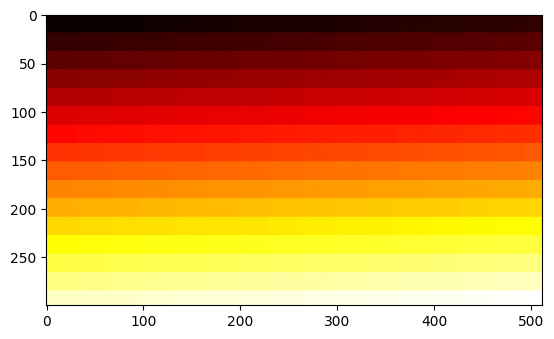

In [4]:
n_box_each_side = int(np.floor(np.sqrt(2**FP_INT)))

width_x_box = IN_COLS//n_box_each_side + 1
x_edges = []
x = 0
while x < IN_COLS:
    x_edges.append(x)
    x += width_x_box

width_y_box = IN_ROWS//n_box_each_side + 1
y_edges = []
y = 0
while y < IN_ROWS:
    y_edges.append(y)
    y += width_y_box


img_precrop_float = np.zeros((IN_ROWS, IN_COLS))
idx = 0
for y1 in y_edges:
    y2 = y1 + width_y_box
    for x1 in x_edges:
        x2 = x1 + width_x_box
        img_precrop_float[y1:y2, x1:x2] = idx
        idx += 1
VMAX = idx

img_precrop = []
for i in range(img_precrop_float.shape[0]):
    img_precrop_i = []
    for j in range(img_precrop_float.shape[1]):
        img_precrop_i.append(int_to_bin(img_precrop_float[i,j], FP_INT))

    img_precrop.append(img_precrop_i)
img_precrop = np.array(img_precrop)

print(f"img_precrop.shape: {img_precrop.shape}")

plt.figure()
plt.imshow(img_precrop_float, cmap='hot', vmin=0, vmax=VMAX)
plt.show()
plt.close()

In [5]:
fpath_img_precrop = os.path.join(top_level_dir, f"img_precrop_Mono8{DATA_STRING_INSERT}.dat")
print(f"fpath_img_precrop: {fpath_img_precrop}")
print(f"len(fpath_img_precrop): {len(fpath_img_precrop)}")

with open(fpath_img_precrop, "w") as f:
    for i in range(img_precrop.shape[0]):
        if i!= 0:
            f.write("\n")

        row = img_precrop[i,:]
        for j in range(img_precrop.shape[1]):
            val = row[j]
            val_hex = str(hex(int(val,2))).replace("0x", "")
            if len(val_hex) < 2:
                new_val_hex = "0"*(2-len(val_hex))+val_hex
                val_hex = new_val_hex
            f.write(f"{val_hex} ")
            
            # print(f"val: {val}, val_hex: {val_hex}")

fpath_img_precrop: /home/aelabd/RHEED/CoaxlinkQuadCxp12_1cam/tb_data_Mono8/300x512_to_48x48x5/img_precrop_Mono8_INDEX.dat
len(fpath_img_precrop): 102


## 2. Post-crop

In [6]:
def plot_borders_norm(ax, crop_boxes_norm, image_size=(100, 160)):
    num_blobs = crop_boxes_norm.shape[0]
    for j in range(num_blobs):
        cbn = crop_boxes_norm[j].copy()
        y1, x1, y2, x2 = cbn
        y1 *= image_size[0]
        x1 *= image_size[1]
        y2 *= image_size[0]
        x2 *= image_size[1]

        ax.plot([x1, x2], [y1, y1], color='blue') # top border
        ax.plot([x1, x1], [y1, y2], color='blue') # left border
        ax.plot([x1, x2], [y2, y2], color='blue') # bottom border
        if j==0:
            ax.plot([x2, x2], [y1, y2], color='blue', label="Bounding box") # right
        else:
            ax.plot([x2, x2], [y1, y2], color='blue') # right
    ax.legend()

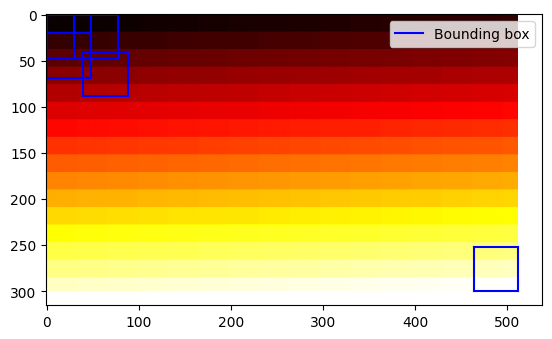

In [7]:
crop_boxes_norm = []
for (y1,x1) in TOP_LEFT_Y1X1:
    y2 = y1 + OUT_ROWS
    y1 *= 1/IN_ROWS
    y2 *= 1/IN_ROWS

    x2 = x1 + OUT_COLS
    x1 *= 1/IN_COLS
    x2 *= 1/IN_COLS
    cbn = [y1, x1, y2, x2]
    crop_boxes_norm.append(cbn)
crop_boxes_norm = np.array(crop_boxes_norm)

fig, ax = plt.subplots(1)
ax.imshow(img_precrop_float, cmap='hot', vmin=0, vmax=VMAX)
plot_borders_norm(ax, crop_boxes_norm, image_size=(IN_ROWS, IN_COLS))
plt.show()
plt.close()

In [8]:
for (Y1, X1) in TOP_LEFT_Y1X1:
    Y2 = Y1+OUT_ROWS
    X2 = X1+OUT_COLS

    img_postcrop_float = img_precrop[Y1:Y2, X1:X2]
    fpath_img_postcrop_hex = os.path.join(top_level_dir, f"Y1_{Y1}_X1_{X1}", f"img_postcrop{DATA_STRING_INSERT}.txt")
    os.makedirs(os.path.dirname(fpath_img_postcrop_hex), exist_ok=True)
    with open(fpath_img_postcrop_hex, "w") as f:
        for i, row in enumerate(img_postcrop_float):
            if i > 0:
                f.write("\n")
            for val in row:
                val_hex = str(hex(int(val,2))).replace("0x", "")
                if len(val_hex) < 2:
                    new_val_hex = "0"*(2-len(val_hex))+val_hex
                    val_hex = new_val_hex
                f.write(f"{val_hex} ")

## 3. Post-norm

In [9]:
for (Y1, X1) in TOP_LEFT_Y1X1:
    Y2 = Y1+OUT_ROWS
    X2 = X1+OUT_COLS

    img_postcrop = img_precrop[Y1:Y2, X1:X2]
    img_postcrop_float = np.array([[bin_to_int(val) for val in row] for row in img_postcrop])

    # print(f"\n\n(Y1,Y2) = {(Y1, Y2)}")
    # print(f"(X1, X2) = {(X1,X2)}")
    # print(f"img_postcrop: {img_postcrop}")
    # print(f"img_postcrop_float: {img_postcrop_float}")

    max_val = np.max(img_postcrop_float)+1
    img_postnorm_float = (img_postcrop_float/max_val).astype(np.float64)
    img_postnorm = np.array([[frac_to_bin(val, n_bits=FP_TOTAL) for val in row] for row in img_postnorm_float])

    fpath_img_postnorm = os.path.join(top_level_dir, f"Y1_{Y1}_X1_{X1}", f"img_postnorm{DATA_STRING_INSERT}.txt")
    os.makedirs(os.path.dirname(fpath_img_postcrop_hex), exist_ok=True)
    with open(fpath_img_postnorm, "w") as f:
        for i, row in enumerate(img_postnorm):
            if i > 0:
                f.write("\n")
            for val in row:
                val_hex = str(hex(int(val,2))).replace("0x", "")
                if len(val_hex) < 2:
                    new_val_hex = "0"*(2-len(val_hex))+val_hex
                    val_hex = new_val_hex
                f.write(f"{val_hex} ")